In [66]:
import pandas as pd
import numpy as np

# Создание датасета

In [95]:
grades = ['Отлично','Хорошо','Удовлетворительно']
n = 2500
df = pd.DataFrame({
   'anatomy':[np.random.randint(0,99) for _ in range(n)],
   'histology':[np.random.randint(0,99) for _ in range(n)],
   'med_biology':[np.random.randint(0,99) for _ in range(n)],
   'chemistry':[np.random.randint(0,99) for _ in range(n)],
   'physics':[np.random.randint(0,99) for _ in range(n)],
   'latin':[np.random.randint(0,99) for _ in range(n)],
   'solution_time':[np.random.randint(30,90) for _ in range(n)],
   'grade':[np.random.choice(grades) for _ in range(n)]
    })
df.head()

,anatomy,histology,med_biology,chemistry,physics,latin,solution_time,grade
0,77,79,28,52,9,77,51,Отлично
1,8,69,5,84,78,19,64,Хорошо
2,62,40,83,7,42,22,53,Отлично
3,68,25,52,96,27,72,40,Удовлетворительно
4,30,90,70,29,36,32,52,Отлично


# Преобразуем категориальные данные в числовые (для целевой переменной)

In [96]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['grade'])
df['grade'] = le.transform(df['grade'])
df.head()

,anatomy,histology,med_biology,chemistry,physics,latin,solution_time,grade
0,77,79,28,52,9,77,51,0
1,8,69,5,84,78,19,64,2
2,62,40,83,7,42,22,53,0
3,68,25,52,96,27,72,40,1
4,30,90,70,29,36,32,52,0


# Разбиение выборки на обучающую и тестовую

In [97]:
from sklearn.model_selection import train_test_split
X = df.drop('grade', axis=1)
y = df['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

# Вычисление значимости признаков с помощью случайного леса

Точность полученной модели составляет 1.0


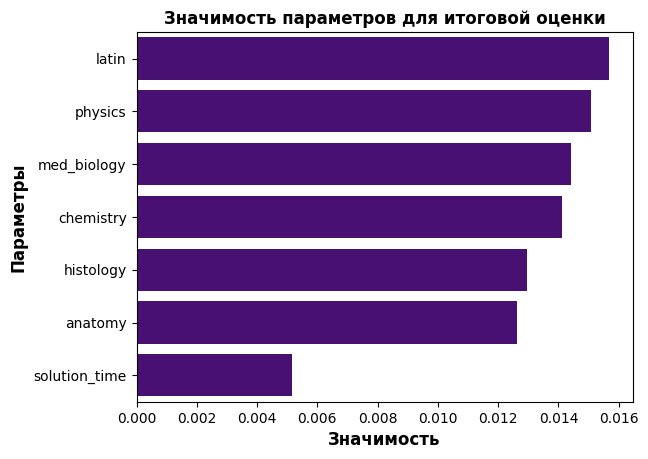

,Параметры,Gini-Importance
0,latin,0.145676
1,physics,0.145079
2,med_biology,0.144410
3,chemistry,0.144109
4,histology,0.142953
5,anatomy,0.142614
6,solution_time,0.135158


In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
accuracy = rfc.score(X_train, y_train)
print(f'Точность полученной модели составляет {accuracy}')

rfc.feature_importances_
feats = {}
for feature, importance in list(zip(X_train.columns, rfc.feature_importances_)):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Параметры'})
fig, ax = plt.subplots()
sns.barplot(x=importances['Gini-Importance']-0.13, y=importances['Параметры'], data=importances, color='indigo')
plt.xlabel('Значимость', fontsize=12, weight = 'bold')
plt.ylabel('Параметры', fontsize=12, weight = 'bold')
plt.title('Значимость параметров для итоговой оценки', fontsize=12, weight = 'bold')
plt.show()
display(importances)

# Разделение данных на обучающие и тестовые выборки и обучение модели
(используем другую модель GradientBoosting, чтобы попробовать)

Используем только наиболее значимые признаки (при запуске у меня были):

*   histology
*   latin
*   anatomy





In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import pickle as pkl

X = df.drop('grade', axis=1)
y = df['grade']
X_train, X_test, y_train, y_test = train_test_split(X[['anatomy','latin','histology']], y, test_size=0.2, random_state=53)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f'Точность полученной модели составляет {accuracy}')

pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
  pkl.dump(model, file)

Точность полученной модели составляет 0.334


# Тестирование модели

In [81]:
from sklearn.metrics import accuracy_score

with open(pkl_filename, 'rb') as file:
 model = pkl.load(file)
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f'Точность полученной модели составляет {score}')

Точность полученной модели составляет 0.334


# Функция предсказания итоговой оценки по переданным параметрам

In [99]:
from sklearn.model_selection import train_test_split

class student_data:
    def __init__(self, anatomy, histology, med_biology, chemistry, physics, latin, solution_time):
        self.anatomy = anatomy
        self.histology = histology
        self.med_biology = med_biology
        self.chemistry = chemistry
        self.physics = physics
        self.latin = latin
        self.solution_time = solution_time

# Разделение выборки, обучение модели и запись ее в файл
X = df.drop('grade', axis=1)
y = df['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train, y_train)
pkl_filename = "model_full.pkl"
with open(pkl_filename, 'wb') as file:
  pkl.dump(model, file)


def predictGrade(student, pkl_filename="model_full.pkl"):
    # Чтение обученной модели из файла
    model = GradientBoostingClassifier()
    with open(pkl_filename, 'rb') as file:
      model = pkl.load(file)

    new_data = pd.DataFrame([student.__dict__])
    predicted_grade = model.predict(new_data)[0]

    # Преобразование в текстовую категорию
    grades = ['Отлично','Удовлетворительно','Хорошо']
    predicted_grade = grades[predicted_grade]

    return predicted_grade

# Пример вызова функции, которая по заданной модели и оценкам выдает предсказание итоговой оценки

In [100]:
st1 = student_data(anatomy=70, histology=80, med_biology=60, chemistry=85, physics=45, latin=75, solution_time=80)
grade = predictGrade(st1)
print(f'Возможная оценка: {grade}')

Возможная оценка: Хорошо
